In [141]:
import findspark
findspark.init()
import pyspark as spark
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [270]:
level = 1
label='primary_site'
L = 3
labels = ['primary_site', 'disease_type', 'disease_tissue']
#labels = ['primary_site', 'secondary_site']
algorithm = 'topsbm'
#labels = ['primary_site', 'secondary_site', 'status']
#labels=['RPPA Clusters']
directory = "/home/fvalle/phd/results/tcga/oversampling_10tissue"
#directory = "/home/fvalle/phd/results/altmann"
#directory = "/Users/filippo/Google Drive File Stream/My Drive/tesi_magistrale/tesi/results/hSBM/highlyvariable_7tissues"
os.chdir(directory)

In [271]:
df_Pwt = sql.read.option('header',True).csv("%s/%s/%s_level_%d_word-dist.csv"%(directory,algorithm,algorithm,L))

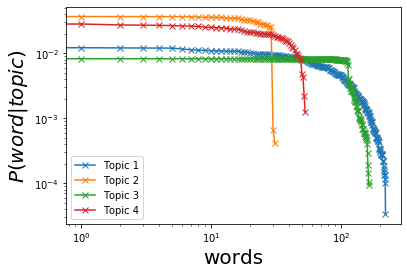

In [272]:
fig=plt.figure()
plt.title("")
for topic in df_Pwt.columns[:5]:
    dist = df_Pwt.select([topic]).filter(F.col(topic)>1e-5).sort([topic], ascending=False).toPandas().astype(float).values
    if len(dist)<2:
        continue
    plt.plot(np.sort(dist[dist>0].T)[::-1], marker='x', label=topic)
plt.ylabel("$P(word | topic$)", fontsize=20)
plt.xlabel("words", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [273]:
df_Ptd = sql.read.option('header',True).csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,L)).drop('i_doc')

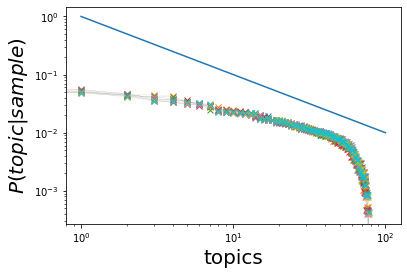

In [274]:
plt.figure()
plt.ylabel("$P(topic | sample$)", fontsize=20)
plt.xlabel("topics", fontsize=20)
for sample in df_Ptd.select('doc').toPandas().values[:10]:
    #plt.plot(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0], marker='x')
    plt.plot(np.sort(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0])[::-1], lw=0.1, marker='x')
plt.plot(np.logspace(0,2),1/np.logspace(0,2))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [275]:
Pgt = tf.convert_to_tensor(df_Pwt.toPandas().set_index('_c0').astype(float).values)
Pts = tf.transpose(tf.convert_to_tensor(df_Ptd.toPandas().set_index('doc').astype(float).values))

In [276]:
Pgt

<tf.Tensor 'Const_8:0' shape=(3739, 79) dtype=float64>

In [277]:
Pts

<tf.Tensor 'transpose_4:0' shape=(79, 793) dtype=float64>

In [278]:
with tf.Session() as sess:
    Pgs = sess.run(tf.matmul(Pgt,Pts))
Pgs.shape

(3739, 793)

In [279]:
df_Pgs = pd.DataFrame(data=Pgs, index=df_Pwt.toPandas().values.T[0], columns=df_Ptd.select(['doc']).toPandas().values.T[0])

In [280]:
df_mt = sql.read.option("header",True).csv("%s/mainTable.csv"%directory)
A = df_mt.toPandas().set_index('_c0').astype(int).sum(axis=1)

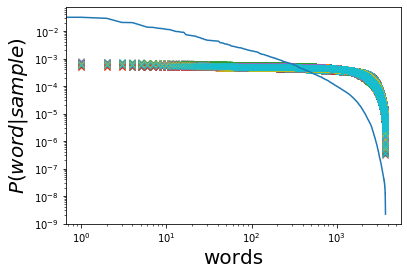

In [281]:
fig=plt.figure()
for doc in df_Pgs.columns[:200]:
    #doc = df_Pgs.columns[0]
    cdf = df_Pgs[doc]
    s_values = cdf[cdf>1e-95].sort_values(ascending=False)
    s_values = s_values/np.sum(s_values)
    plt.plot(s_values.values, marker='x', lw=0)
plt.plot(A.sort_values(ascending=False)/A.sum())
plt.ylabel("$P(word | sample$)", fontsize=20)
plt.xlabel("words", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [282]:
A_hsbm = df_Pgs.apply(lambda x: np.average(x), axis=1)

In [287]:
def get_tissue(sample, samples=None):
    for fullsample in samples.index.values:
        if sample in fullsample:
            return samples.loc[fullsample,:]

In [283]:
df_file=pd.read_csv("%s/files.dat"%directory, index_col=0)

In [288]:
df_Ptissueg = df_Pgs.transpose()
df_Ptissueg.insert(0,'tissue',[get_tissue(t,samples=df_file)['primary_site'] for t in df_Pgs.columns])
df_Ptissueg=df_Ptissueg.groupby('tissue').mean().sort_values('tissue')
df_Ptissueg

,ENSG00000000005,ENSG00000002745,ENSG00000004776,ENSG00000004846,ENSG00000004848,ENSG00000004939,ENSG00000004948,ENSG00000005102,ENSG00000005381,ENSG00000005421,...,ENSG00000279847,ENSG00000280021,ENSG00000280090,ENSG00000280094,ENSG00000280197,ENSG00000280204,ENSG00000280236,ENSG00000280267,ENSG00000280969,ENSG00000281106
tissue,,,,,,,,,,,,,,,,,,,,,
Bone Marrow,0.000417,0.000430,0.000454,0.000403,0.000384,0.000375,0.000385,0.000404,0.000559,0.000372,...,0.000105,0.000007,0.000011,0.000038,0.000033,1.374853e-06,0.000023,0.000007,0.000210,0.000496
Brain,0.000371,0.000402,0.000434,0.000383,0.000441,0.000347,0.000383,0.000412,0.000433,0.000386,...,0.000096,0.000010,0.000010,0.000030,0.000035,1.223824e-06,0.000018,0.000008,0.000270,0.000441
Breast,0.000322,0.000445,0.000466,0.000380,0.000403,0.000478,0.000417,0.000454,0.000435,0.000363,...,0.000162,0.000006,0.000008,0.000030,0.000034,1.062059e-06,0.000019,0.000008,0.000166,0.000383
Esophagus,0.000348,0.000396,0.000435,0.000370,0.000346,0.000432,0.000368,0.000398,0.000368,0.000383,...,0.000177,0.000006,0.000009,0.000025,0.000038,1.148413e-06,0.000020,0.000009,0.000217,0.000414
Kidney,0.000337,0.000425,0.000452,0.000525,0.000384,0.000415,0.000376,0.000442,0.000441,0.000402,...,0.000102,0.000006,0.000009,0.000030,0.000036,1.113509e-06,0.000021,0.000008,0.000195,0.000401
Lung,0.000308,0.000449,0.000455,0.000345,0.000393,0.000384,0.000412,0.000452,0.000443,0.000416,...,0.000075,0.000006,0.000008,0.000030,0.000037,1.015494e-06,0.000020,0.000008,0.000149,0.000366
Lymph Nodes,0.000268,0.000453,0.000494,0.000286,0.000411,0.000366,0.000420,0.000510,0.000447,0.000414,...,0.000096,0.000006,0.000007,0.000031,0.000035,8.845837e-07,0.000021,0.000008,0.000195,0.000319
Ovary,0.000352,0.000410,0.000434,0.000348,0.000386,0.000436,0.000397,0.000415,0.000406,0.000392,...,0.000102,0.000006,0.000009,0.000028,0.000035,1.162495e-06,0.000020,0.000008,0.000182,0.000419
Prostate,0.000302,0.000441,0.000455,0.000368,0.000416,0.000453,0.000409,0.000524,0.000425,0.000432,...,0.000070,0.000007,0.000008,0.000029,0.000033,9.982103e-07,0.000019,0.000008,0.000193,0.000360


In [311]:
test = df_file.index[np.random.randint(len(df_file.index))]
sample_vector = df_mt.toPandas().set_index('_c0').loc[df_Ptissueg.columns,test]
df_file.loc[test,]

primary_site                                Ovary
disease_type    Ovarian Serous Cystadenocarcinoma
Name: 3769209b-a12f-4a84-9d68-0e1c934e5aea.htseq.counts.gz, dtype: object

In [312]:
proj = np.matmul(df_Ptissueg.values.astype(float),sample_vector.values.astype(float))
proj = proj/np.sum(proj)
pd.DataFrame(data=proj, index=df_Ptissueg.index).sort_values(0,ascending=False)

,0
tissue,
Lymph Nodes,0.082198
Thyroid,0.081415
Uterus,0.080040
Soft Tissue,0.079875
Breast,0.078458
Lung,0.077295
Prostate,0.076929
Kidney,0.076135
Bone Marrow,0.075567


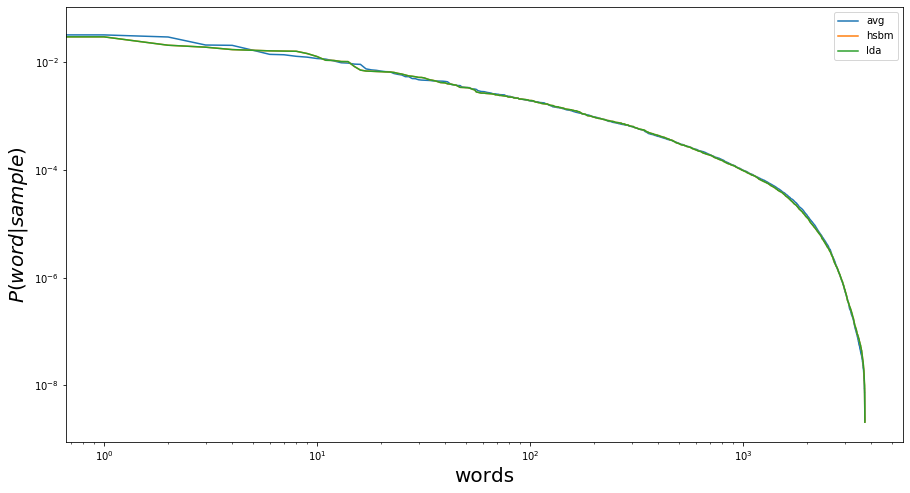

In [134]:
fig=plt.figure(figsize=(15,8))
plt.plot(np.sort(A.values)[::-1]/np.sum(A), label='avg')
plt.plot(np.sort(A_hsbm.values)[::-1]/np.sum(A_hsbm.values), label='hsbm')
plt.plot(np.sort(A_lda.values)[::-1]/np.sum(A_lda.values), label='lda')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('words', fontsize=20)
plt.ylabel('$P(word|sample)$', fontsize=20)
plt.legend()
plt.show()
fig.savefig("zipf_algo.pdf")

In [ ]:
A.divide(A.sum()).sort_values(ascending=False)

In [98]:
A_hsbm.sort_values(ascending=False)

b888bce3-6b9e-494b-b1e8-    0.000267
4e2d8faa-1d4a-41d6-ad45-    0.000267
5f02561f-c7c7-4cea-997e-    0.000267
aafeade1-c999-487f-9a76-    0.000267
c8f587c1-595c-4617-9f03-    0.000267
                              ...   
3e7a9494-07e7-4f19-a646-    0.000267
7f2cf950-b5e1-4a01-a44b-    0.000267
cbf6d499-8616-4519-bca1-    0.000267
213d57e8-a4e9-4f31-b711-    0.000267
f1af54f4-3006-4136-b0db-    0.000267
Length: 793, dtype: float64

In [103]:
A_lda.divide(A_lda.sum()).sort_values(ascending=False)

ENSG00000131095    4.448453e-02
ENSG00000005381    2.907551e-02
ENSG00000115705    2.033162e-02
ENSG00000167751    1.870529e-02
ENSG00000168878    1.687791e-02
                       ...     
ENSG00000280204    5.363011e-09
ENSG00000214642    5.253700e-09
ENSG00000169800    4.255077e-09
ENSG00000226023    2.263489e-09
ENSG00000215269    2.076249e-09
Length: 3739, dtype: float64